In [1]:
! lamin load jkobject/scprint

→ connected lamindb: jkobject/scprint


In [3]:
import scanpy as sc

from scprint import scPrint
from scprint.tasks import Embedder

from scdataloader import Preprocessor
from scdataloader.utils import load_genes, translate

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

from scdataloader.utils import get_descendants
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

from collections import Counter

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


→ connected lamindb: jkobject/scprint2


## preparing the model

In [4]:
loc = "../data/temp/o2uniqsx/epoch=18-step=133000.ckpt"
    # "/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/last.ckpt"
    #'../data/temp/o2uniqsx/epoch=18-step=133000.ckpt',
    #"../../xzp23r4p.ckpt"

m = torch.load(loc)
if "label_counts" in m['hyper_parameters']:
    model = scPrint.load_from_checkpoint(loc, precpt_gene_emb=None, classes=m['hyper_parameters']['label_counts'])
else:
    model = scPrint.load_from_checkpoint(loc, precpt_gene_emb=None)

RuntimeError caught: scPrint is not attached to a `Trainer`.


## Loading the data

In [7]:
#only dataset dropped
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad') 

# one that it trained on: z7ZZxORUQFshySbuvNW7. 2PN6LTuSmJI2TSGl77TY.h5ad
# untrained on: BljRloq1xjcxRNDpejzI
# testdatasets=['/R4ZHoQegxXdSFNFY5LGe.h5ad', '/SHV11AEetZOms4Wh7Ehb.h5ad', '/V6DPJx8rP3wWRQ43LMHb.h5ad', '/Gz5G2ETTEuuRDgwm7brA.h5ad', '/YyBdEsN89p2aF4xJY1CW.h5ad', '/SO5yBTUDBgkAmz0QbG8K.h5ad', '/r4iCehg3Tw5IbCLiCIbl.h5ad', '/SqvXr3i3PGXM8toXzUf9.h5ad', '/REIyQZE6OMZm1S3W2Dxi.h5ad', '/rYZ7gs0E0cqPOLONC8ia.h5ad', '/FcwMDDbAQPNYIjcYNxoc.h5ad', '/fvU5BAMJrm7vrgDmZM0z.h5ad', '/gNNpgpo6gATjuxTE7CCp.h5ad'],

In [11]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


  0%|          | 0.00/301M [00:00<?, ?B/s]

In [5]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [6]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
preprocessor = Preprocessor(use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())
adata

X was not raw counts, using 'counts' layer
Dropping layers:  KeysView(Layers with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 32472 renamining
filtered out 191 cells, 32281 renamining
Removed 0 genes.
startin QC
Seeing 10359 outliers (32.09% of total dataset):
done
AnnData object with n_obs × n_vars = 32281 × 70704
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbo

AnnData object with n_obs × n_vars = 32281 × 70704
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

# good dataset

In [7]:
embed = Embedder(how="random expr", max_len=4000, add_zero_genes=0, num_workers=16, pred_embedding = ["cell_type_ontology_term_id"])

100%|██████████| 256/256 [07:18<00:00,  1.71s/it]


AnnData object with n_obs × n_vars = 16382 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:161: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="sprint_leiden")


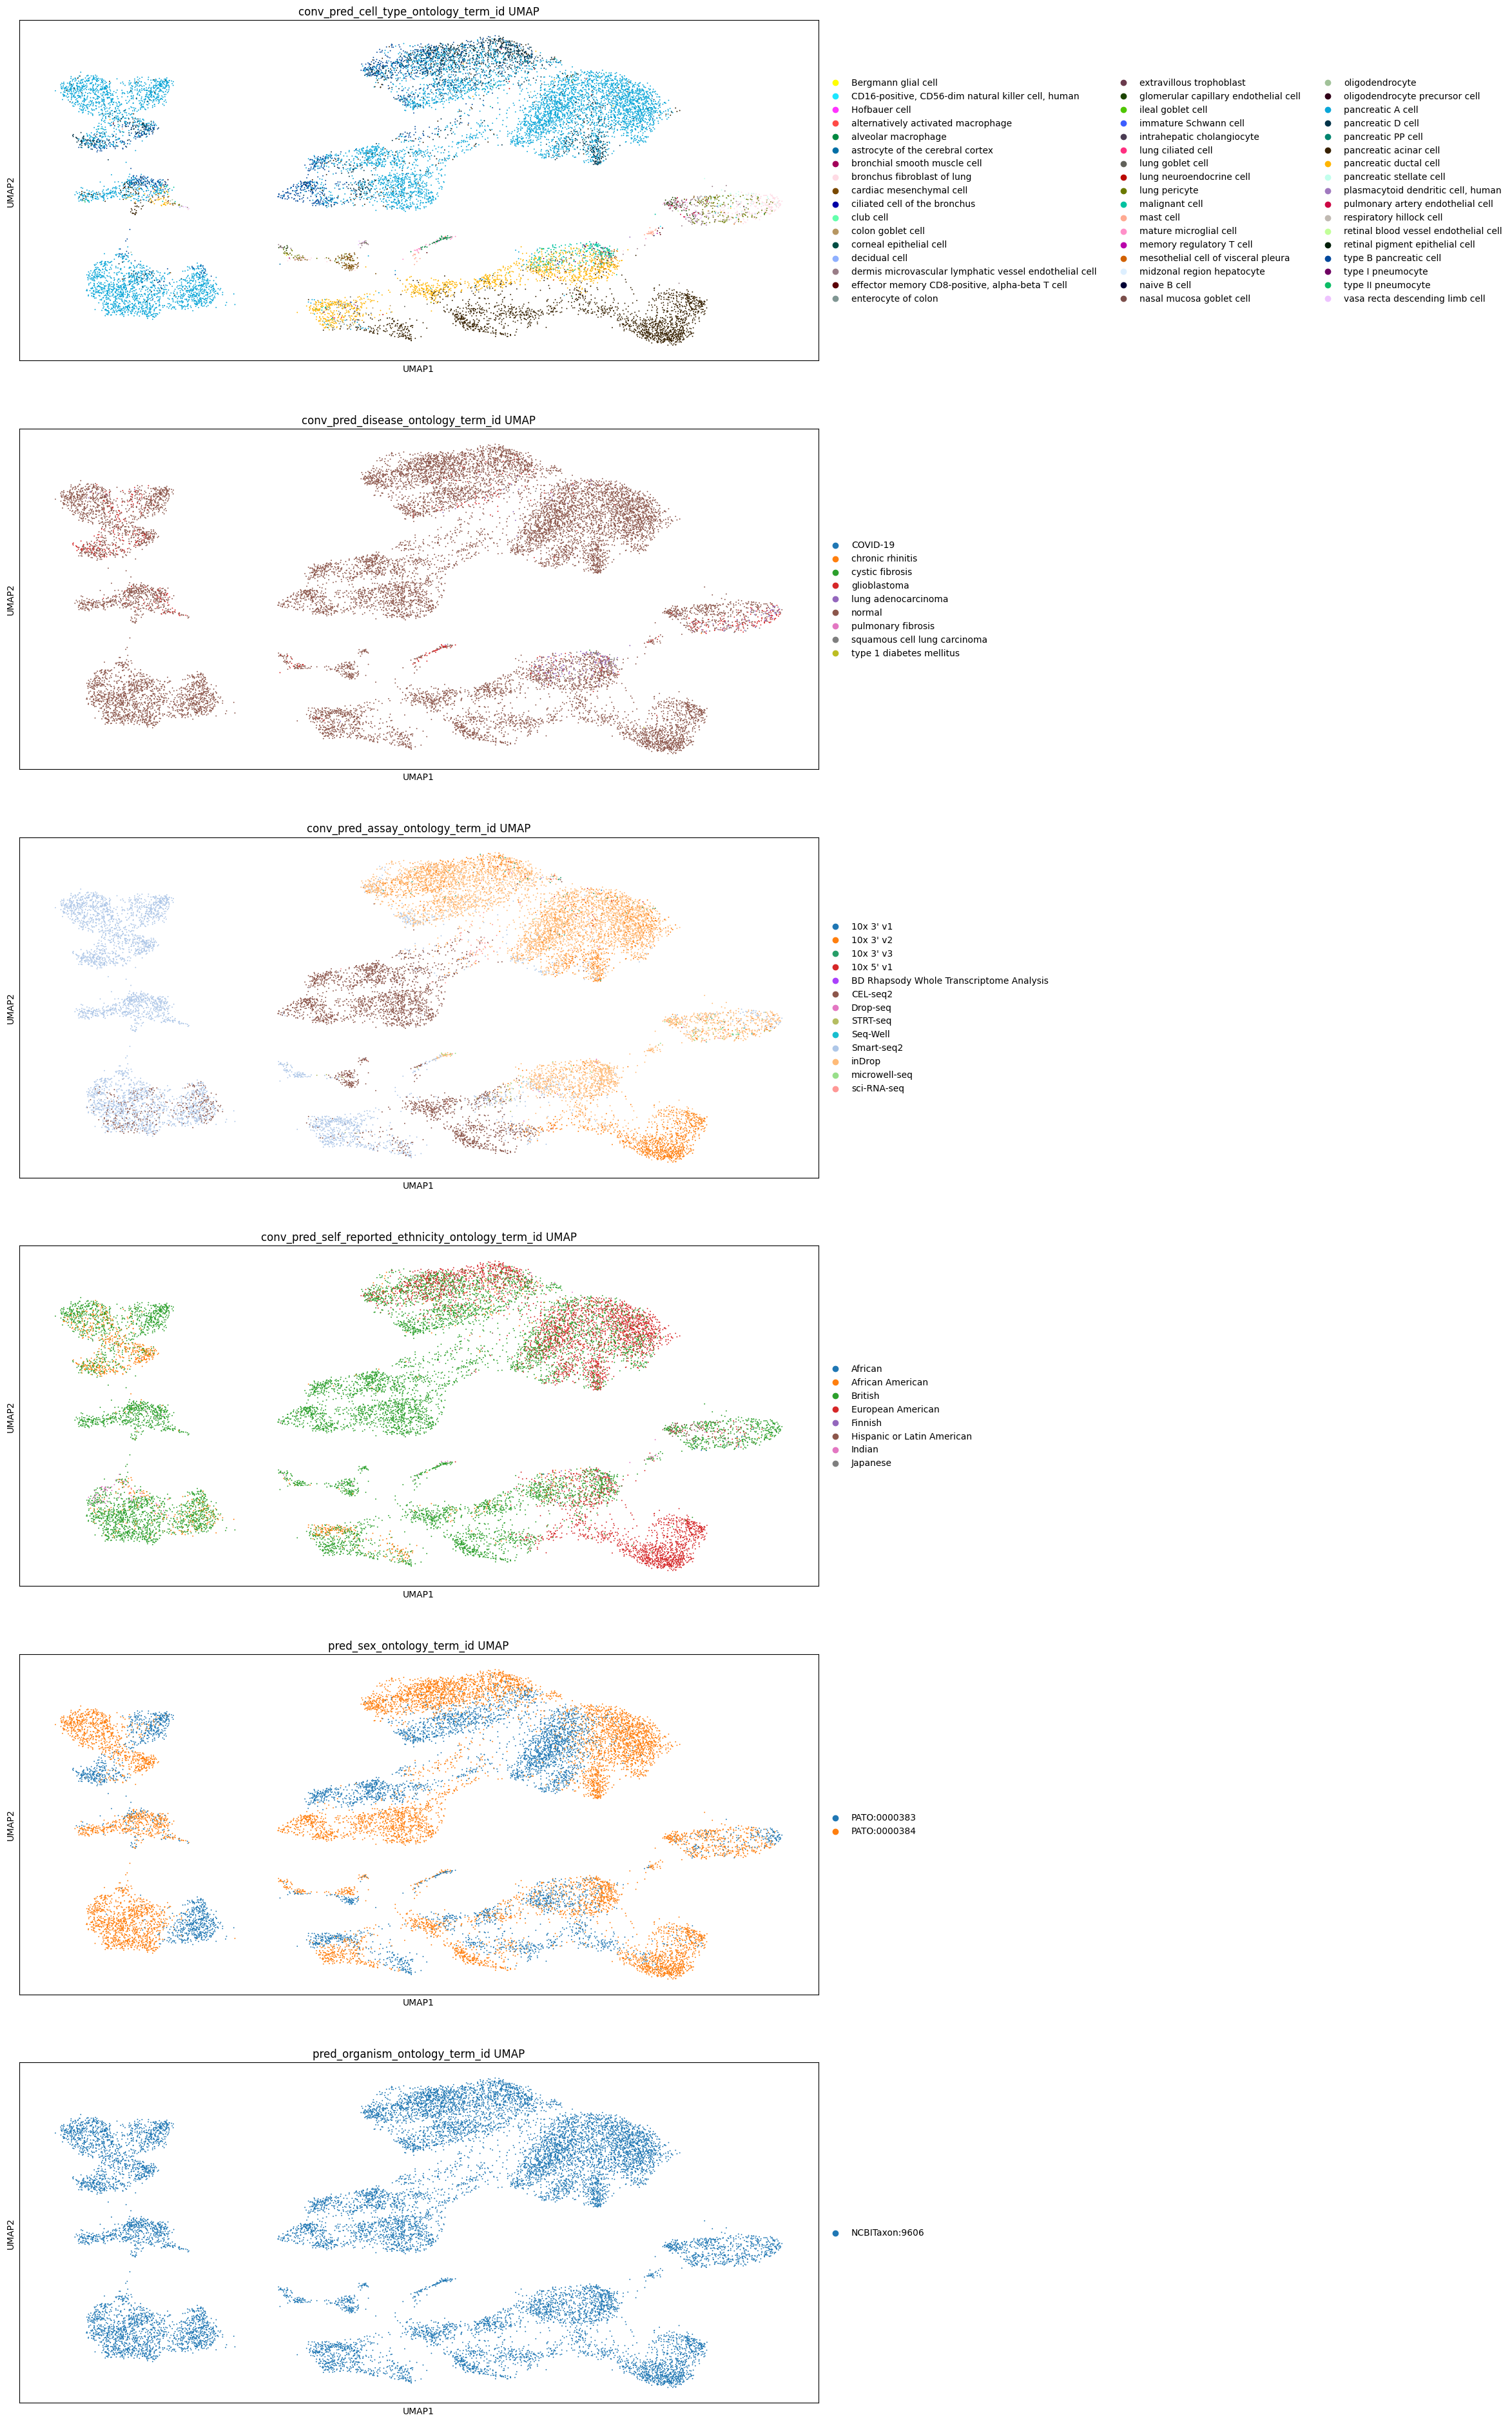

couldn't log to tensorboard
couldn't log to wandb
too few cells to compute a clustering
     organism_ontology_term_id
     accuracy: 1.0
 


In [24]:
n_adata, metrics = embed(model, adata.copy(), cache=False)

In [9]:
bm.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_pca,0.986674,0.169118,-0.03597,0.140068,0.999792,0.723814,0.064232,0.12585,0.643677,0.0,0.311515,0.451936,0.395768
scprint,0.607016,0.452205,0.241164,0.518234,0.996269,0.90184,0.019406,0.142276,0.735256,0.020525,0.363861,0.562978,0.483331
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [26]:
sc.pp.pca(n_adata)

In [14]:
n_adata

AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'sprint_leiden'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_by_id', 'mt', 'rib

In [37]:
bm = Benchmarker(
    n_adata,
    batch_key="tech", #batch, tech
    label_key="celltype", #celltype
    embedding_obsm_keys=["X_pca", "scprint"],
    n_jobs=20,
)
bm.benchmark()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in 

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj)

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Metrics:  70%|███████   | 7/10 [01:42<00:33, 11.23s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 2/2 [02:35<00:00, 77.51s/it]


In [28]:
bm.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_pca,0.467313,0.447298,0.243881,0.4366,0.999649,0.820935,0.009778,0.223245,0.767836,0.0,0.364359,0.518948,0.457113
scprint,0.612311,0.573306,0.351891,0.554444,0.98092,0.758008,0.12749,0.378531,0.76681,0,0.406168,0.614574,0.531212
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [19]:
bm.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_pca,0.986674,0.169118,-0.03597,0.140068,0.999792,0.723814,0.064232,0.124337,0.643677,0.0,0.311212,0.451936,0.395647
scprint,0.457001,0.482981,0.350381,0.506738,0.984933,0.748845,0.235566,0.323618,0.678685,0.626727,0.522688,0.556407,0.542919
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [10]:
bm.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_pca,0.467313,0.447298,0.243881,0.4366,0.999649,0.820935,0.009778,0.223245,0.767836,0.0,0.364359,0.518948,0.457113
scprint,0.614566,0.606962,0.416326,0.53608,0.988221,0.893546,0.07539,0.337603,0.87245,0,0.435798,0.632431,0.553778
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [19]:
bm.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_pca,0.986674,0.169118,-0.03597,0.140068,0.999792,0.723814,0.064232,0.124337,0.643677,0.0,0.311212,0.451936,0.395647
scprint,0.628811,0.46042,0.256694,0.523536,0.989782,0.882578,0.082825,0.217717,0.772832,0.383229,0.467836,0.571849,0.530244
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


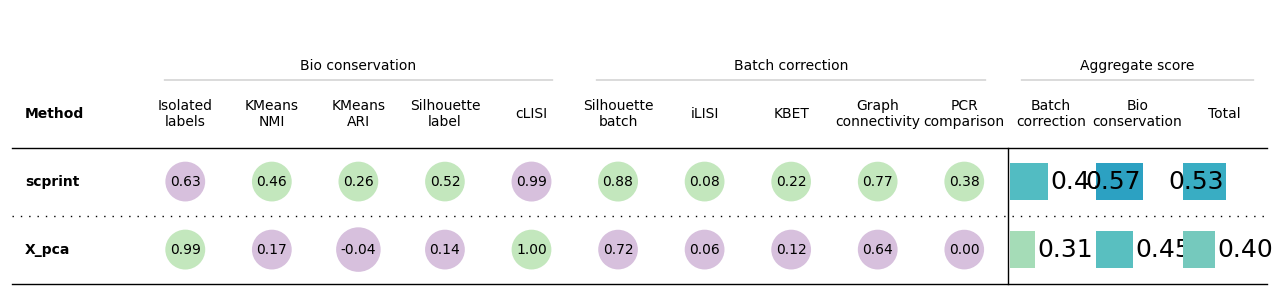

In [16]:
bm.plot_results_table(min_max_scale=False)

[autoreload of scprint.tasks.cell_emb failed: Traceback (most recent call last):
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ml4ig1/Documents code/scPRINT/scprint/tasks/cell_emb.py", line 371
   

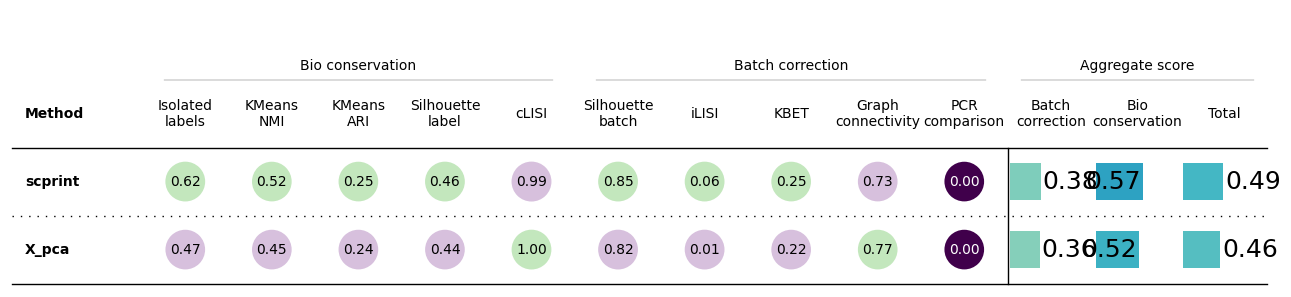

In [9]:
bm.plot_results_table(min_max_scale=False)

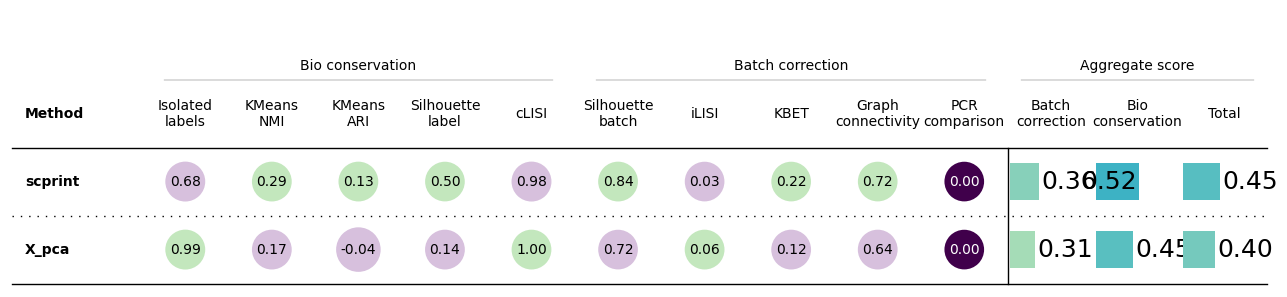

In [18]:
# previous 
bm.plot_results_table(min_max_scale=False)

In [19]:
n_adata.obs.celltype.value_counts()

celltype
alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
mast                    42
epsilon                 32
schwann                 25
t_cell                   7
Name: count, dtype: int64

In [20]:
n_adata.obs.loc[n_adata.obs.celltype=="activated_stellate"].conv_pred_cell_type_ontology_term_id.value_counts()

conv_pred_cell_type_ontology_term_id
bronchus fibroblast of lung                               421
lung pericyte                                               7
alveolar type 2 fibroblast cell                             6
dermis microvascular lymphatic vessel endothelial cell      5
malignant cell                                              4
                                                         ... 
fibroblast of breast                                        0
fast muscle cell                                            0
extravillous trophoblast                                    0
erythroid progenitor cell, mammalian                        0
ventricular cardiac muscle cell                             0
Name: count, Length: 91, dtype: int64

In [10]:
import bionty as bt

[autoreload of scprint.tasks.cell_emb failed: Traceback (most recent call last):
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ml4ig1/Documents code/scPRINT/scprint/tasks/cell_emb.py", line 373
   

In [15]:
obj = bt.CellType.public(organism="all")
{i: obj.search(i, field="name").ontology_id.iloc[0] for i in set(n_adata.obs['cell_type'])}

{'Type 2': 'CL:0000784',
 'Macrophage': 'CL:0000235',
 'Mast cell': 'CL:0000097',
 'Ciliated': 'CL:0005012',
 'Ionocytes': 'CL:0005006',
 'Basal 1': 'CL:0000646',
 'Neutrophil_CD14_high': 'CL:0000775',
 'B cell': 'CL:0000236',
 'Type 1': 'CL:0000990',
 'Endothelium': 'CL:2000009',
 'Neutrophils_IL1R2': 'CL:0000775',
 'Lymphatic': 'CL:0009107',
 'Fibroblast': 'CL:0000057',
 'T/NK cell': 'CL:0000623',
 'Secretory': 'CL:0011003',
 'Basal 2': 'CL:0000646',
 'Dendritic cell': 'CL:0000451'}

In [38]:
fine = {"gamma": "CL:0002275",
"beta": "CL:0000169", # "CL:0008024"
"epsilon": "CL:0005019", # "CL:0008024"
"acinar": "CL:0000622",
'delta': 'CL:0000173', #"CL:0008024"
'schwann': 'CL:0002573', # "CL:0000125"
'activated_stellate': 'CL:0000057',
'alpha': 'CL:0000171',# "CL:0008024"
'mast': 'CL:0000097',
'Mast cell': 'CL:0000097',
'quiescent_stellate': 'CL:0000057',
't_cell': 'CL:0000084',
'endothelial': 'CL:0000115',
'Endothelium': 'CL:0000115',
'ductal': 'CL:0002079', #CL:0000068
'macrophage': 'CL:0000235',
'Macrophage': 'CL:0000235',
'B cell': 'CL:0000236',
'Type 2': 'CL:0002063',
'Type 1': 'CL:0002062',
'Ciliated': 'CL:4030034', # respiratory ciliated
'Dendritic cell': 'CL:0000451', #leukocyte
'Secretory': 'CL:0000151',
'Ionocytes': 'CL:0005006',
'Basal 1': 'CL:0000646', # epithelial
'Basal 2': 'CL:0000646',
'Neutrophil_CD14_high': 'CL:0000775',
'Neutrophils_IL1R2': 'CL:0000775',
'Lymphatic': 'CL:0002138',
'Fibroblast': 'CL:0000057',
'T/NK cell': 'CL:0000814',

'inDrop1': 'EFO:0008780',
'inDrop3': 'EFO:0008780',
'inDrop4': 'EFO:0008780',
'inDrop2': 'EFO:0008780',
'fluidigmc1': 'EFO:0010058', #fluidigm c1
'smarter': 'EFO:0010058', #fluidigm c1
'celseq2': 'EFO:0010010',
'smartseq2': 'EFO:0008931',
'celseq': 'EFO:0008679',
}
coarse = {
"beta": "CL:0008024", #endocrine
"epsilon": "CL:0008024",
'delta': "CL:0008024",
'alpha': "CL:0008024",
"gamma": "CL:0008024",
"acinar": "CL:0000150", #epithelial (gland)
'ductal': "CL:0000068", #epithelial (duct)
'schwann': "CL:0000125", # glial
'endothelial': 'CL:0000115',
'Endothelium': 'CL:0000115',
'Lymphatic': 'CL:0000115',
'macrophage': 'CL:0000235', #myeloid leukocyte (not) 
'Macrophage': 'CL:0000235', # myeloid leukocyte
'mast': 'CL:0000097', #myeloid leukocyte (not)
'Mast cell': 'CL:0000097', #myeloid leukocyte
'Neutrophil_CD14_high': 'CL:0000775', #myeloid leukocyte
'Neutrophils_IL1R2': 'CL:0000775', #myeloid leukocyte
't_cell': 'CL:0000084', #leukocyte, lymphocyte (not)
'T/NK cell': 'CL:0000084', #leukocyte, lymphocyte (not)
'B cell': 'CL:0000236', #leukocyte, lymphocyte (not)
'Dendritic cell': 'CL:0000451', #leukocyte, lymphocyte
'activated_stellate': 'CL:0000057', # fibroblast (not)
'quiescent_stellate': 'CL:0000057', # fibroblast (not)
'Fibroblast': 'CL:0000057',
'Type 2': 'CL:0000066', # epithelial
'Type 1': 'CL:0000066',
'Ionocytes': 'CL:0000066', # epithelial
'Basal 1': 'CL:0000066', # epithelial
'Basal 2': 'CL:0000066',
'Ciliated': 'CL:0000064', # ciliated
'Secretory': 'CL:0000151',

'inDrop1': 'EFO:0008780',
'inDrop3': 'EFO:0008780',
'inDrop4': 'EFO:0008780',
'inDrop2': 'EFO:0008780',
'fluidigmc1': 'EFO:0010058', #fluidigm c1
'smarter': 'EFO:0010058', #fluidigm c1
'celseq2': 'EFO:0010010',
'smartseq2': 'EFO:0008931',
'celseq': 'EFO:0008679',
}


In [39]:
n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(fine) #fine, coarse
#n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(coarse)

/tmp/ipykernel_1176997/2747151874.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(fine) #fine, coarse


In [40]:
import bionty as bt
metrics = {}
for label in model.classes:
    res = []
    if label not in n_adata.obs.columns:
        continue
    labels_topred = model.label_decoders[label].values()
    if label in model.labels_hierarchy:
        parentdf = (
            bt.CellType.filter()
            .df(include=["parents__ontology_id"])
            .set_index("ontology_id")[['parents__ontology_id']]
        )
        parentdf.parents__ontology_id = parentdf.parents__ontology_id.astype(str)
        class_groupings = {
            k: get_descendants(k, parentdf)
            for k in set(n_adata.obs[label].unique())
        }
    for pred, true in n_adata.obs[["pred_" + label, label]].values:
        if pred == true:
            res.append(true)
            continue
        if label in model.labels_hierarchy:
            if true in class_groupings:
                res.append(true if pred in class_groupings[true] else "")
                continue
            elif true not in labels_topred:
                raise ValueError(f"true label {true} not in available classes")
        elif true not in labels_topred:
            raise ValueError(f"true label {true} not in available classes")
        res.append("")
    metrics[label] = {}
    metrics[label]['accuracy'] = np.mean(np.array(res)== n_adata.obs[label].values)
    metric_type = [ "macro", "micro", "weighted" ]
    for x in metric_type:
        metrics[label][x] = f1_score(
            np.array(res), 
            n_adata.obs[label].values, 
            average=x
        )
metrics

{'cell_type_ontology_term_id': {'accuracy': 0.17146868514222927,
  'macro': 0.3146321916271462,
  'micro': 0.17146868514222927,
  'weighted': 0.08652248274514393},
 'organism_ontology_term_id': {'accuracy': 1.0,
  'macro': 1.0,
  'micro': 1.0,
  'weighted': 1.0}}

In [ ]:
# micro == accuracy

In [15]:
metrics

{'cell_type_ontology_term_id': {'accuracy': 0.6403369551947259,
  'macro': 0.5636411799720809,
  'micro': 0.6403369551947259,
  'weighted': 0.5499500004907383},
 'organism_ontology_term_id': {'accuracy': 1.0,
  'macro': 1.0,
  'micro': 1.0,
  'weighted': 1.0}}

## coarse on others

In [7]:
sc.pp.normalize_total(adata, inplace=True, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata)

In [8]:
adata

AnnData object with n_obs × n_vars = 16382 × 70933
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [38]:
adata.obs['cell_type_ontology_term_id'] = adata.obs['celltype'].replace(coarse) #fine, coarse
#n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(coarse)

/tmp/ipykernel_320935/3261479931.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['cell_type_ontology_term_id'] = adata.obs['celltype'].replace(coarse) #fine, coarse


In [1]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import f1_score

In [49]:
classifier = KNeighborsClassifier()

In [46]:
classifier = LogisticRegression()

In [23]:
classifier = HistGradientBoostingClassifier()

In [41]:
adata.obs.tech.value_counts()

tech
inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: count, dtype: int64

In [43]:
r = np.random.choice(adata.obs.tech.unique(), size=3, replace=False)
train = ~adata.obs.tech.isin(r)
test = adata.obs.tech.isin(r)
# Calculate the ratio of train to test samples
train_count = sum(train)
test_count = sum(test)
ratio = train_count / (test_count + train_count)

print(f"Ratio of train to test: {ratio:.2f}")


Ratio of train to test: 0.73


In [35]:
# Select a random subset of 50% of the data from adata
#train = np.random.choice(adata.shape[0], size=int(adata.shape[0] * 0.7), replace=False)
#test = ~np.isin(np.arange(adata.shape[0]), train)

In [50]:
classifier.fit(adata.obsm["X_pca"][train], adata.obs[train]["cell_type_ontology_term_id"].astype(str))

KNeighborsClassifier()

In [51]:
label_pred = classifier.predict(adata.obsm["X_pca"][test])
metric_type = [ "macro", "micro", "weighted" ]
metrics = {}
for x in metric_type:
    metrics[x] = f1_score(
        label_pred, 
        adata.obs["cell_type_ontology_term_id"].values[test], 
        average=x
    )
metrics

{'macro': 0.8121513675001497,
 'micro': 0.9765395894428153,
 'weighted': 0.9769613890444663}

In [89]:
Counter(adata.obs["cell_type_ontology_term_id"])

Counter({'CL:0008024': 11448,
         'CL:0000068': 2142,
         'CL:0000150': 1669,
         'CL:0000057': 657,
         'CL:0000115': 313,
         'CL:0000235': 79,
         'CL:0000097': 42,
         'CL:0000125': 25,
         'CL:0000084': 7})

In [90]:
from collections import Counter

# Find the most common label
most_common_label = Counter(adata.obs["cell_type_ontology_term_id"]).most_common(1)[0][0]

# Compute the metrics on the majority vote of the most common label
majority_vote_pred = np.full_like(label_pred, fill_value=most_common_label)

majority_vote_metrics = {}
for x in metric_type:
    majority_vote_metrics[x] = f1_score(
        majority_vote_pred, 
        adata.obs["cell_type_ontology_term_id"].values[test], 
        average=x
    )
majority_vote_metrics


{'macro': 0.09194991055456173,
 'micro': 0.7058285016783643,
 'weighted': 0.8275491949910555}

# celltypist

In [1]:
import celltypist
from celltypist import models

In [31]:
import scanpy as sc
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


In [32]:
sc.pp.normalize_total(adata, inplace=True, target_sum=1e4)
sc.pp.log1p(adata)
adata.write("data/pancreas_celltypist_log.h5ad")

In [7]:
models.models_description()

🔎 No available models. Downloading...
📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 52
📂 Storing models in /home/ml4ig1/.celltypist/data/models
💾 Downloading model [1/52]: Immune_All_Low.pkl
💾 Downloading model [2/52]: Immune_All_High.pkl
💾 Downloading model [3/52]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/52]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/52]: Adult_Human_MTG.pkl
💾 Downloading model [6/52]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/52]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/52]: Adult_Human_Skin.pkl
💾 Downloading model [9/52]: Adult_Mouse_Gut.pkl
💾 Downloading model [10/52]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [11/52]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [12/52]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [13/52]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [14/52]: COVID19_HumanChallenge_Blood.pkl
💾 Downloadin

,model,description
0,Autopsy_COVID19_Lung.pkl,cell types from the lungs of 16 SARS-CoV-2 inf...
1,Human_AdultAged_Hippocampus.pkl,cell types from the hippocampus of adult and a...
2,COVID19_Immune_Landscape.pkl,immune subtypes from lung and blood of COVID-1...
3,Developing_Mouse_Brain.pkl,cell types from the embryonic mouse brain betw...
4,Human_Developmental_Retina.pkl,cell types from human fetal retina
5,Mouse_Whole_Brain.pkl,cell types from the whole adult mouse brain
6,Healthy_Human_Liver.pkl,cell types from scRNA-seq and snRNA-seq of the...
7,Healthy_Mouse_Liver.pkl,cell types from scRNA-seq and snRNA-seq of the...
8,Cells_Adult_Breast.pkl,cell types from the adult human breast
9,Fetal_Human_Pancreas.pkl,pancreatic cell types from human embryos at 9-...


In [54]:
pred = celltypist.annotate("data/pancreas_celltypist_log.h5ad", model = 'Adult_Human_PancreaticIslet.pkl')

📁 Input file is 'data/pancreas_celltypist_log.h5ad'
⏳ Loading data


🔬 Input data has 16382 cells and 19093 genes
🔗 Matching reference genes in the model
🧬 1747 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [43]:
adata.obs.celltype.value_counts()

celltype
alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
mast                    42
epsilon                 32
schwann                 25
t_cell                   7
Name: count, dtype: int64

In [55]:
predictions = pred.predicted_labels
predictions.value_counts()

predicted_labels    
delta                   5082
alpha_stress II         2116
PP                      1984
alpha_MHC II            1830
alpha_immature          1392
beta_immature            756
beta_MHC/autoantigen     754
beta_stress I            751
beta_stress II           624
alpha_mature             593
beta_mature              468
beta_mtDNA deficient      32
Name: count, dtype: int64

In [56]:
rename = {
    "alpha_stress II": "alpha",
    "alpha_stress I": "alpha",
    "alpha_MHC II": "alpha",
    "alpha_mature": "alpha",
    "PP": "gamma",
    "alpha_immature": "alpha",
    "beta_immature": "beta",
    "beta_MHC/autoantigen": "beta",
    "beta_stress I": "beta",
    "beta_stress II": "beta",
    "beta_mature": "beta",
    "beta_mtDNA deficient": "beta",
    "delta": "delta",
}
predictions.predicted_labels = predictions.predicted_labels.map(rename)

In [57]:
predictions.value_counts()

predicted_labels
alpha               5931
delta               5082
beta                3385
gamma               1984
Name: count, dtype: int64

In [47]:
from sklearn.metrics import f1_score

In [58]:
predictions.predicted_labels = predictions.predicted_labels.astype(str)
adata.obs["celltype"] = adata.obs["celltype"].astype(str)

In [59]:
metric_type = ["macro", "micro", "weighted"]
metrics = {}
for x in metric_type:
    metrics[x] = f1_score(
        predictions.predicted_labels,
        adata.obs["celltype"],
        average=x
    )
metrics

{'macro': 0.15663170324558137,
 'micro': 0.5032352582102307,
 'weighted': 0.555239923073986}